# MLGO: Deep Neural Network for Gene Ontology Prediction

## Preliminary Analysis Report

**By: [Tony Kabilan Okeke](mailto:tko35@drexel.edu)**

### Data Preparation

- For this project, I am using RNA-seq datasets from the *Digital Expression Explorer 2*
  repository.
- I am using their mouse (*M. musculus*) datasets.
- For each dataset, I am performing differential expression analysis using the
  `limma` package in R, followed by Gene Ontology enrichment analysis using the
  `GOfuncR` package. (See `scripts/loaddatasets.R` for details.)
- The datasets are then cleaned and saved as a single `DataFrame` in the
  `data/processed/clean-data.feather` file.
  - The features are log fold changes of each of the genes sequenced, and the
    labels are the Gene Ontology terms that are enriched in the dataset.
- For this report, 100 datasets were processed and saved. Datasets whose rows
  contain `NA` values did not contain enough groups to perform differential
  expression analysis.

In [21]:
# Imports
import matplotlib.pyplot as plt
import feather as ft
import pandas as pd
import numpy as np
import yaml

# Load config
with open('config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load data
df = ft.read_dataframe(config['paths']['processed'])

# Drop NAs
df = df.dropna()

### Separate Data into Features and Labels

In [32]:
# Split data into features and labels
samples = df['GSE'].to_numpy()
X = df.iloc[:,1:-1].values
y = df['GO_terms']
features = df.columns[1:-1] # Remove GSE and GO_terms

print("There are {} samples (datasets) and {} features (genes).".format(X.shape[0], X.shape[1]))

There are 70 samples (datasets) and 49045 features (genes).


### One-Hot Encode GO Terms

- Here, I will convert the lists of GO terms in `y` into a one-hot encoded matrix.
- To limit the number of output labels, I will only use GO terms that appear in
  at least 30 datasets.
  - When training the model, this threshold will be adjusted based on how
    many datasets are available.

In [33]:
# One-hot encode labels
y = y.str.get_dummies(sep=";")
print("There are {} GO terms in total.".format(y.shape[1]))

# Remove GO terms that occur less than 10 times
y = y.loc[:, (y.sum() > 30)]
labels = y.columns
Y = y.values

# Sort labels by frequency
freq = Y.sum(axis=0)
idx = np.argsort(freq)[::-1]
Y = Y[:,idx]
labels = labels[idx]

print("There are {} GO terms that occur more than 10 times.".format(Y.shape[1]))

There are 5299 GO terms in total.
There are 89 GO terms that occur more than 10 times.


### Target Class Distribution

- Due to the large number of GO terms (target classes), I will show their
  distribution in a bar chart, instead of the required pie chart.

Text(0, 0.5, 'Frequency')

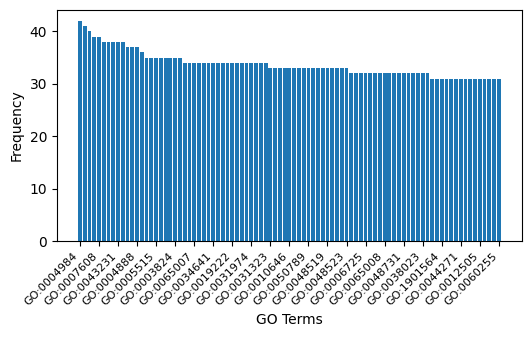

In [53]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(labels, freq[idx])
ax.set_xticks(np.arange(0, len(labels), 4))
ax.set_xticklabels(labels[::4], rotation=45, ha='right', fontsize=8);
ax.set_xlabel('GO Terms')
ax.set_ylabel('Frequency')

### Attribute Distribution & Correlation

- In the table generated below, the correlation is calculated between each
  attribute (gene) and the most prevalent GO term in the dataset.

In [68]:
# Create a dataframe with the min, max, mean, std of each feature
df_stats = pd.DataFrame({
    'min': X.min(axis=0), 
    'max': X.max(axis=0), 
    'mean': X.mean(axis=0), 
    'std': X.std(axis=0)
}, index=features)
df_stats = df_stats.sort_values(by='mean', ascending=False)
df_stats.head()

# Calculater correlation of each feature with the first label
corr = np.zeros(X.shape[1])
for i in range(X.shape[1]):
    corr[i] = np.corrcoef(X[:,i], Y[:,0])[0,1]
df_stats['corr_' + labels[0]] = corr

# Show top 10 features with highest correlation with the first label
df_stats.sort_values(by='corr_' + labels[0], ascending=False).head(10)

/home/muaddib/.conda/envs/mlgo/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/muaddib/.conda/envs/mlgo/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,min,max,mean,std,corr_GO:0004984
Vmn1r-ps86,-0.166667,43.022222,0.868100,5.493269,0.326846
Il1rn,-577.250000,2895.625000,101.922069,487.813546,0.308222
Rad23b,-5409.023810,11768.933333,78.477999,2163.028045,0.302761
A330044P14Rik,-0.380066,24.178261,0.358458,2.869636,0.300433
Ccdc120,-1254.600000,2779.000000,27.636136,468.283669,0.299827
Pcsk9,-2283.250000,9560.375000,296.422229,1445.636375,0.296206
Gm15509,-127.166667,217.068966,4.243981,36.538720,0.296048
Arl14epl,0.000000,0.000000,0.000000,0.000000,0.295745
G630064G18Rik,0.000000,2.222222,0.031746,0.263702,0.294614
Exoc3l4,-6568.000000,10366.500000,113.985305,1485.916886,0.291873
